<div class="alert alert-warning">
    <h1>Synthetic Morphology</h1>
</div>


Comparison of original and new methods of growing crystal.

Original used sobel filter to find edges and grow from there.

New method uses queue of crystal sites that is updated as the crystal grows

In the plots below, the original seeded points are shown as white dots

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from crystalgrowth import *
import time

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
norm = mpl.colors.Normalize(vmin=-np.pi/2, vmax=np.pi/2)  # use same scale for all plots

In [4]:
def plotvals(size, n_sites, anisotropy=3, seed=274813, mutation=0, periodic=False):
    nuc_array = np.empty(size)
    nuc_array[:] = np.nan
    nuc_array, pos, orients = nucleate(nuc_array, n_sites, seed)

    fig, ax = plt.subplots(1, 2, figsize=(16,8))
    start = time.time()
    grown_array = grow_complete(nuc_array, growth_anisotropy=anisotropy,
                                pi_mutate=np.deg2rad(mutation), c_mutate=np.deg2rad(mutation))
    end = time.time()
    grown_array[pos[:, 0], pos[:, 1]] = np.nan  # mark the seed values
    im0 = ax[0].imshow(grown_array, norm=norm, cmap='hsv')
    ax[0].set_title(f"original \n(time={end - start:.2f}s)", fontsize=18)

    start = time.time()
    grown_array = grow_complete_queue(nuc_array, growth_anisotropy=anisotropy,
                                      pi_mutate=np.deg2rad(mutation), c_mutate=np.deg2rad(mutation),
                                      do_periodic=periodic)
    end = time.time()
    grown_array[pos[:, 0], pos[:, 1]] = np.nan
    im1 = ax[1].imshow(grown_array, norm=norm, cmap='hsv')
    ax[1].set_title(f"queueing \n(time={end - start:.2f}s)", fontsize=18);

# Basic comparison with no mutation

Results are visually similar. There are minor differences due to the order that points are grown, which will differ between the methods.

/home/user/code/4DSTEMtranslator/crystalgrowth.py:124: RuntimeWarning: invalid value encountered in greater
  grow_array[grow_array > np.pi/2] %= -np.pi/2
/home/user/code/4DSTEMtranslator/crystalgrowth.py:125: RuntimeWarning: invalid value encountered in less
  grow_array[grow_array < -np.pi/2] %= np.pi/2


almost done


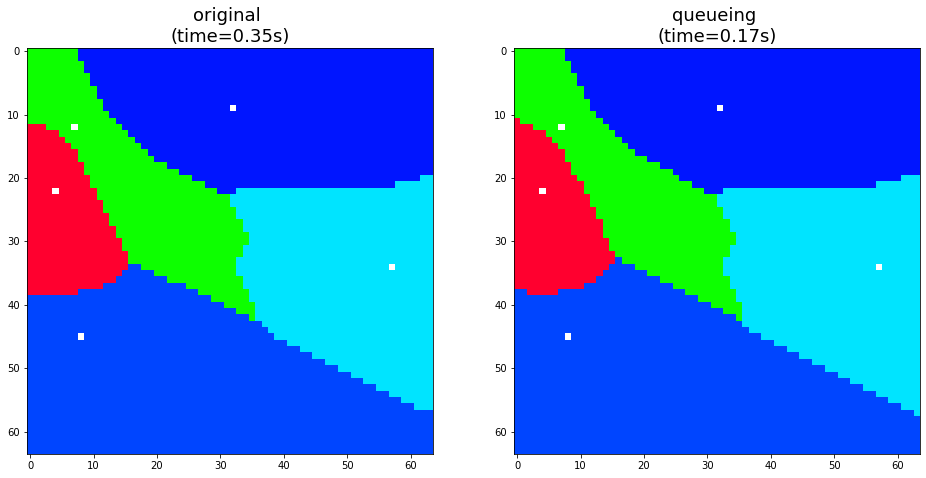

In [5]:
plotvals(size=(64,64), n_sites=5)

almost done


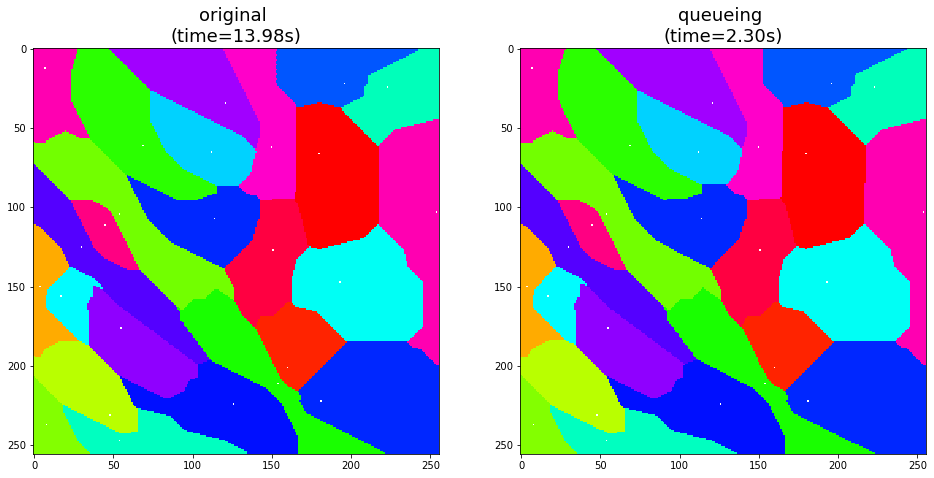

In [6]:
plotvals(size=(256,256), n_sites=25)

### High anisotropy case

Performance of qeueing is significantly better. This may be due to final stages of growth where only the minor axis grows. The original method does edge checking for each step even if nothing is needed. The queuing method short circuits the unproductive steps.

almost done


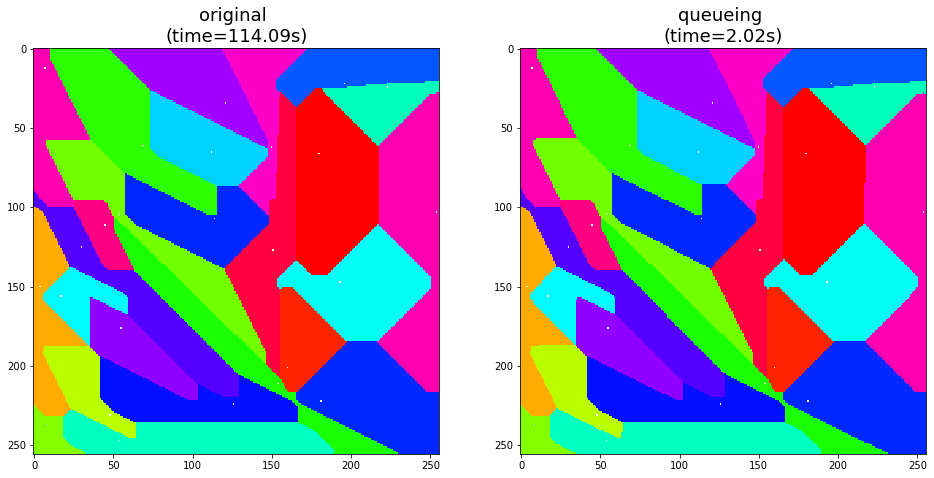

In [7]:
plotvals(size=(256,256), n_sites=25, anisotropy=25)

### Periodic case - not periodic

The original method has a very slight periodic behaviour but it does not grow in a periodic manner. This can be seen on the right side of the original image. The 3 points grew from the seed on the left side. The queing method explictly blocks this behaviour unless periodicity is requested.

The periodic points in the original method never grow, possibly because the edge detection doesn't pick them up?

almost done


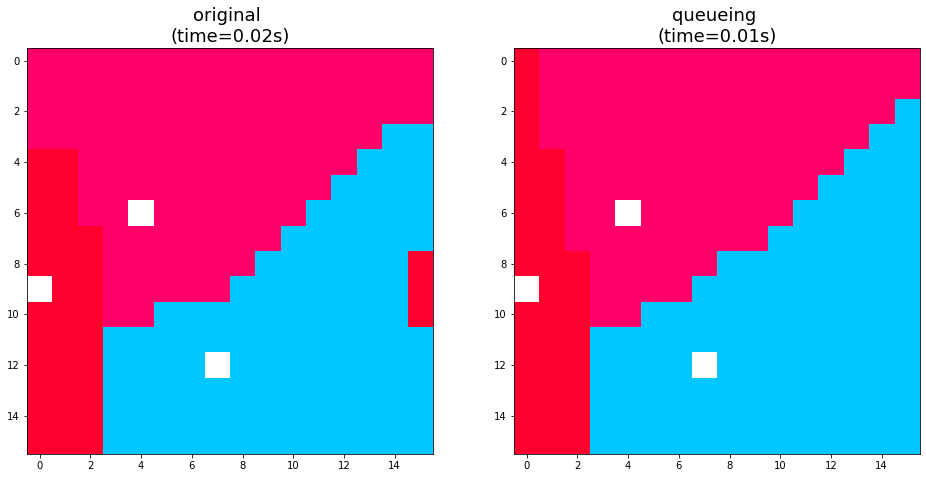

In [8]:
plotvals(size=(16,16), n_sites=3, periodic=False)

### Periodic case - periodic

Turning on periodicity in the queueing method allows growth across periodic bounds, as shown below. Unlike the original method, the points do grow when they cross the boundary

almost done


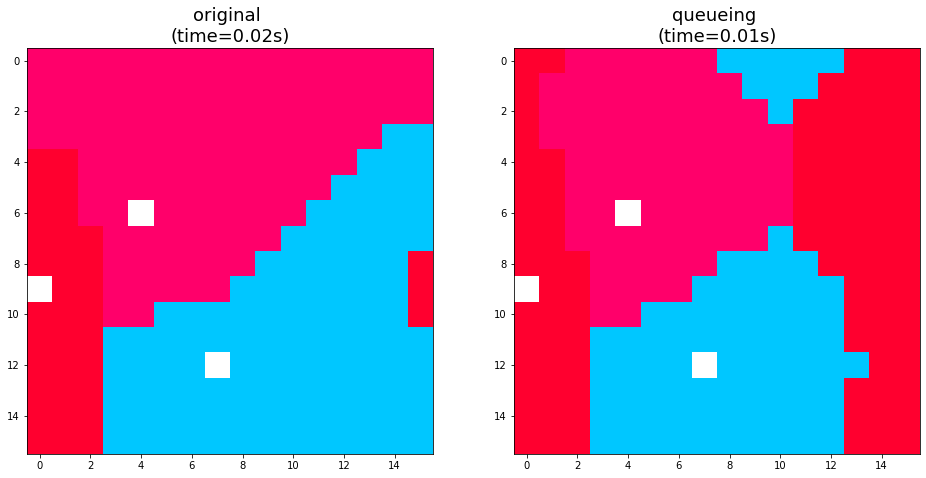

In [9]:
plotvals(size=(16,16), n_sites=3, periodic=True)

### Periodic case - periodic (larger system)

almost done


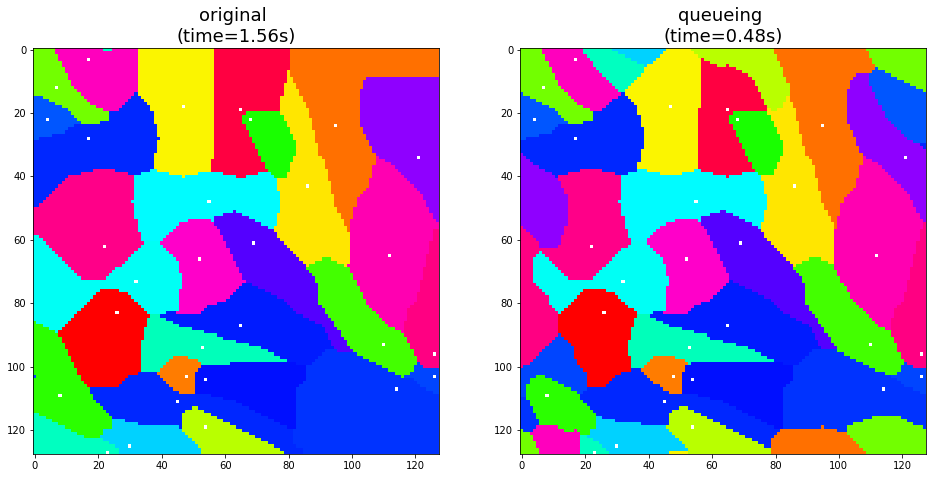

In [10]:
plotvals(size=(128,128), n_sites=30, periodic=True)

# Growth Animation

/home/user/code/4DSTEMtranslator/crystalgrowth.py:124: RuntimeWarning: invalid value encountered in greater
  grow_array[grow_array > np.pi/2] %= -np.pi/2
/home/user/code/4DSTEMtranslator/crystalgrowth.py:125: RuntimeWarning: invalid value encountered in less
  grow_array[grow_array < -np.pi/2] %= np.pi/2


almost done


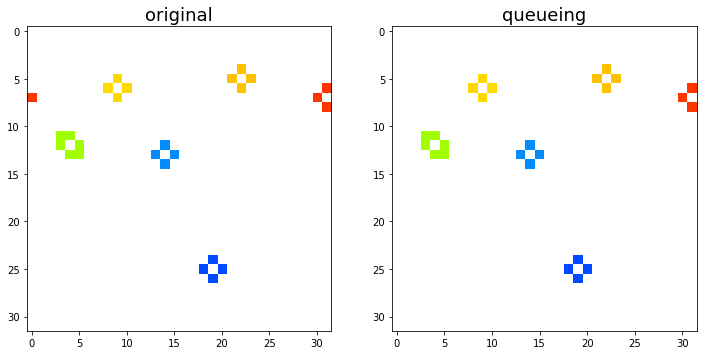

In [11]:
import matplotlib.animation

nuc_array = np.empty((32,32))
nuc_array[:] = np.nan
nuc_array, pos, orients = nucleate(nuc_array, 6, 56123)
norm = mpl.colors.Normalize(vmin=-np.pi/2, vmax=np.pi/2)

mutation = 0
anisotropy = 5

fig, ax = plt.subplots(1,2,figsize=(12,6))

orig = []
queueing = []
for debug in range(42):
    orig.append(grow_complete(nuc_array, growth_anisotropy=anisotropy,
                            pi_mutate=np.deg2rad(mutation), c_mutate=np.deg2rad(mutation), debug=debug))
    orig[-1][pos[:, 0], pos[:, 1]] = np.nan  # mark seed values

    queueing.append(grow_complete_queue(nuc_array, growth_anisotropy=anisotropy,
                                  pi_mutate=np.deg2rad(mutation), c_mutate=np.deg2rad(mutation),
                                  do_periodic=False, debug=debug))
    queueing[-1][pos[:, 0], pos[:, 1]] = np.nan
    
im0 = ax[0].imshow(orig[0],norm=norm,cmap='hsv')
ax[0].set_title("original", fontsize=18)
im1 = ax[1].imshow(queueing[0],norm=norm,cmap='hsv')
ax[1].set_title("queueing", fontsize=18)

def animate(i):
    im0.set_data(orig[i])
    im1.set_data(queueing[i])

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(orig));

from IPython.display import HTML
HTML(ani.to_jshtml())

# Using mutation

There are no differences in the handling of mutation. However the results will show more variation across methods due to random number sequences

/home/user/code/4DSTEMtranslator/crystalgrowth.py:124: RuntimeWarning: invalid value encountered in greater
  grow_array[grow_array > np.pi/2] %= -np.pi/2
/home/user/code/4DSTEMtranslator/crystalgrowth.py:125: RuntimeWarning: invalid value encountered in less
  grow_array[grow_array < -np.pi/2] %= np.pi/2


almost done


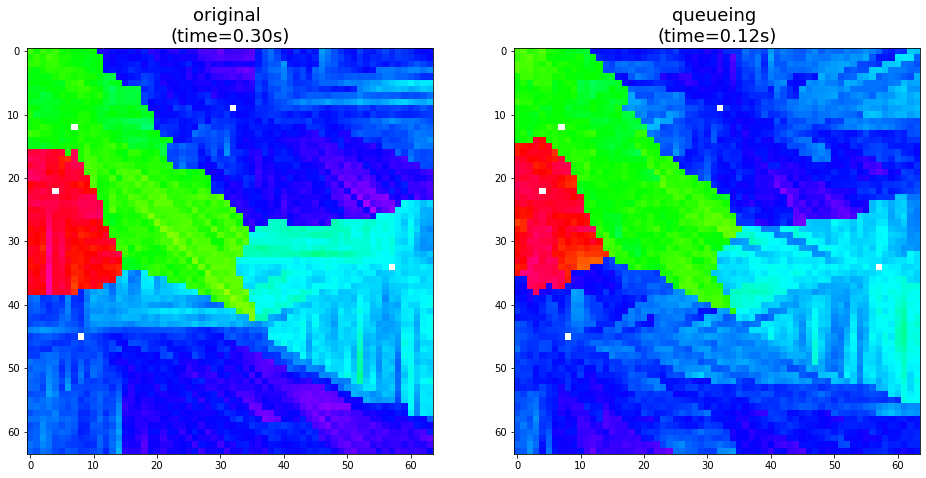

In [12]:
plotvals(size=(64,64), n_sites=5, mutation=3)

almost done


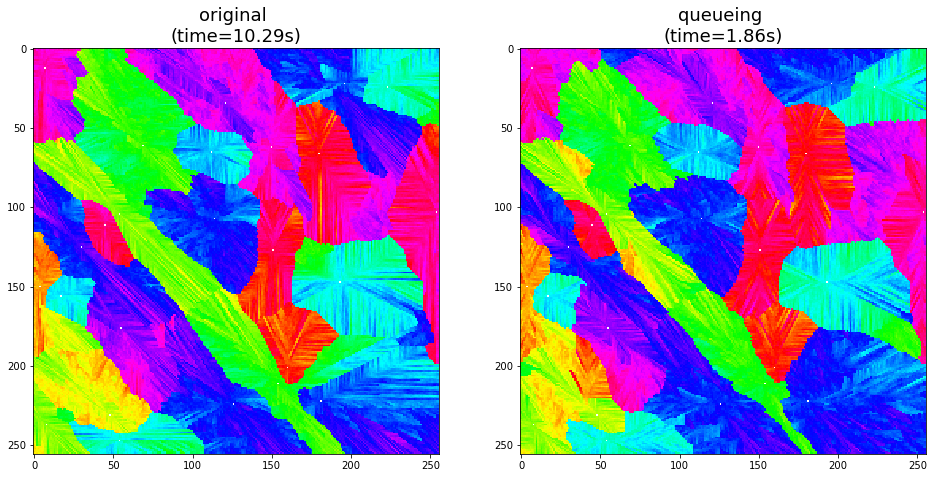

In [13]:
plotvals(size=(256,256), n_sites=25, mutation=3)

<div class="alert alert-warning">
    <h1>Healing</h1>
</div>

Comparison of the old and new methods of growth to heal a structure with missing data

In [14]:
from translator import *
import glob

In [15]:
filelist = glob.glob('11 C9*')
ss, q, chi, data = load_npy(filelist[0],2)

In [16]:
data_sub = subtract_powerlaw(q, data, qmin_exclude=1)

In [17]:
peaks, num_peaks, data_1d = peak_finder(q, chi, data_sub, qmin_exclude=1.3, prominence=10)
gauss_params = fit_peaks(chi, data_1d, peaks, num_peaks)

In [18]:
gpos, gint, gfwhm, bck = list_to_array(gauss_params)

## Unhealed structure

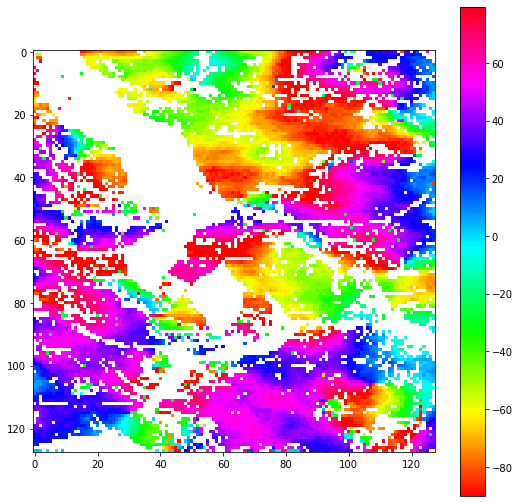

In [19]:
fwhm_mask = (gfwhm[:,0] < 5) | (gfwhm[:,0] > 20) | (gint[:,0] < 5)
orientation_array = gpos[:,0].copy()
orientation_array[fwhm_mask] = np.nan
plt.figure(figsize=(9,9))
implot(orientation_array,cmap='hsv')
plt.colorbar()
plt.show()

## Healed structure

/home/user/code/4DSTEMtranslator/crystalgrowth.py:124: RuntimeWarning: invalid value encountered in greater
  grow_array[grow_array > np.pi/2] %= -np.pi/2
/home/user/code/4DSTEMtranslator/crystalgrowth.py:125: RuntimeWarning: invalid value encountered in less
  grow_array[grow_array < -np.pi/2] %= np.pi/2


almost done


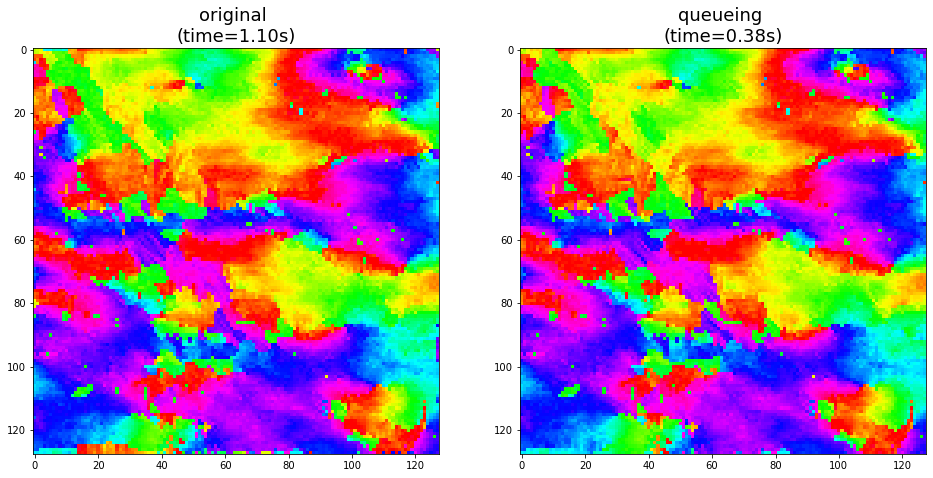

In [20]:
orientation_array = np.reshape(orientation_array,(128,128))

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

start = time.time()
healed_array = grow_complete(np.deg2rad(orientation_array), growth_anisotropy=3)
end = time.time()

im0 = ax[0].imshow(healed_array, norm=norm, cmap='hsv')
ax[0].set_title(f"original \n(time={end - start:.2f}s)", fontsize=18)

start = time.time()
healed_array_queue = grow_complete_queue(np.deg2rad(orientation_array), growth_anisotropy=3)
end = time.time()

im1 = ax[1].imshow(healed_array_queue, norm=norm, cmap='hsv')
ax[1].set_title(f"queueing \n(time={end - start:.2f}s)", fontsize=18);